# Tutorial 1: Collecting and Saving Limit Order Book (LOB) Changes to an .xlsx file"
In this tutorial we show how to use crobat.crobat to manage an LOB updates from open WebSocket connections at the level 2 and ticker levels.

The Steps we will take:
 * Step 0: preliminaries, setting the directory so we can import crobat # have to stanrdardize imports
 * Step 1: Imports, and managing the working directory
 * Step 2: Defining the Settings Class
 * Step 3: Constructing the WebSocket connection
 * Step 4: Verifying File Contents
 * Step 5: Visualizing order book events
 * Step 6: Visualizing order book statistics

## Step 0: Preliminaries, Doublecheck that our imports will work
Doublecheck that whatever directory you are using can import crobat. Below we will run the cell that will
1. move the cwd two directories back ( 'package_directory'<--crobat<--jupyter nbs ),
2. append the cwd to the sys.path list.

Notes:
As of (08/18/2021) most people have to .zip download, or git-clone, and may have to do this step.
To test the directories, try printing os.getcdw(), and sys.path[-1] and making sure it's what you want. 

In [1]:
import os, sys
os.chdir('../..')
wd = os.getcwd()
sys.path.append(wd)

## Step 1: Importing crobat.crobat
crobat.crobat is the module that contains the sub-modules that let us
1. [connect to the coinbase exchange using the CoPrA WS API,](recorder.py)
2. [allow us to create and mantain a LOB](orderbook.py),
3. [help orderbook.py execute functions](orderbookhelpers.py)
4. [allow us to save to file](filesave.py)

In the cell below we simply import the recorder from crobat.crobat, along with the Channel and Client classes from copra.websocket.

In [2]:
from crobat.crobat import recorder as rec
from copra.websocket import Channel, Client

## Step 2: Defining the Settings class, input_args
crobat.crobat requires the following settings to work
1. a currency pair from the [accepted coinbase list](https://coinbasepro.com/pairs),
2. an ordinal position range (i.e., how many price levels from the best bid/ask),
3. recording duration in seconds,
4. sides in the form of a list of strings (e.g., ['bid','ask', 'signed']),
5. output filetype in the form of a list of strings (e.g., ['xlsx'])

We define the input_args class that is passed as an argument when initializing our orderbook. 

**The cell below defines the inputs_args class, and creates an instance of the class as a variable named settings**

Notes: 
you can test whether your class has the appropriate attributes by check dir(settings)

In [3]:
class input_args(object):
    def __init__(self, currency_pair='ETH-USD',
                       position_range=5,
                       recording_duration=5,
                       sides=['bid','ask'],
                       filetype=['xlsx']):
    
        self.currency_pair = currency_pair
        self.position_range = position_range
        self.recording_duration = recording_duration
        self.sides = sides
        self.filetype = filetype
settings = input_args()

## Step 3: Constructing the WebSocket Connection 
This websocket connection format is derived from [CoPrA's documentation](),
which is itself derived from [coinbase's documentation]().

I should include an executable script, if you'd like to follow. The steps we will take are
1. import asyncio, nestasyncio 
2. defining the event loop
3. defining the subscription channels, (channel='level2', channel2='ticker')
4. defining the websocket object, where we pass:
    * the event loop,
    * channel
    * settings
5. subscribing to the ticker channel (channel2)
6. we then try running the loop forever

Note: While not exactly the best practice, the ws variable contains the methods to
start, maintain and end the WebSocket connection. 

In [4]:
import asyncio
import nest_asyncio #used only for jupyter nb
nest_asyncio.apply()
loop = asyncio.get_event_loop()
channel = Channel('level2', settings.currency_pair) 
channel2 =Channel('ticker', settings.currency_pair)
ws = rec.L2_Update(loop, channel, settings)
ws.subscribe(channel2)
try:
    loop.run_forever()
except KeyboardInterrupt:
    loop.run_until_complete(ws.close())
    loop.close()

Let's count the L2 messages! 2021-08-19 10:30:32.894385
Connection to server is closed
True
None
None


SystemExit: 

/home/ivan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Step 3 (cont.): Understanding Text outputs
The output text is unchanged from the CoPrA, example
it is a good confirmiation that the connections was open/closed
sucessfully.The 'System Exit' in this notebook is because I havent figured
out how to make clean asyncio loop closes in jupyter.

The messages you should see:
1.  'Let's count the L2 messages! + utc_timestamp'  --> sucessfully  connected and collecting messagtes
2.  'Connection to server is closed' once the process is done collecting
3. Websocket connection closure messages
    * True --> the connection was closed cleanly
    * Code --> Error code if not closed cleanly default None
    * Reason ---> debugging string to look into. 

## Step 4: Examining output files
Let's take a look at our output files for recording both bid and ask sides. 

Each side will have the following output files containg the word:
1. events: detailing the insertion,cancellation, and market order events
2. prices: price levels in quote currency up through the specified position limit 
3. volm: queue sizes in terms of base currency corresponding the the price levels

In [5]:
import pandas as pd 
df_list = []
for i in os.listdir():
    if i.endswith(".xlsx"):
        print(i)
        df_list.append(pd.read_excel(i))

L2_orderbook_volm_bid2021-08-19 10:30:37.947469.xlsx
L2_orderbook_prices_ask2021-08-19 10:30:37.947469.xlsx
L2_orderbook_volm_ask2021-08-19 10:30:37.947469.xlsx
L2_orderbook_prices_bid2021-08-19 10:30:37.947469.xlsx
L2_orderbook_events_bid2021-08-19 10:30:37.947469.xlsx
L2_orderbook_events_ask2021-08-19 10:30:37.947469.xlsx


## Step 4(cont.): Examining output files
We see from the cell above we have 6 files. if you would like to further examine the files
examine the list of dfs in the jupyter variables console. 

## Step 5: Visualizing the Events File
The events file is arranged as follows
1. Timestamp : timestamp
2. event type : insertion, cancellation, market
3. size : size of the event in base currency
4. position : orindal distance from best bid/ask where the event took place 
5. midprice : (best_bid + best_ask) / 2 
6. spread : best_ask - best_bid

See the docs for more info on the events file.

The two simplest time-series statistics to plot would be the mid price, and the spread
Lets run the cell below to:
1. get the ex

Notes: couldn't get the 

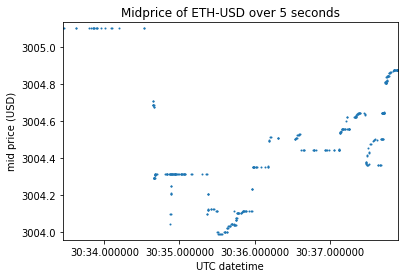

In [7]:
# visualizing the events
import matplotlib.pyplot as plt
# add the mid price to the events as the the plotting of the concatenation of bid and as events
bid_events = pd.read_excel('L2_orderbook_events_bid2021-08-19 10:30:37.947469.xlsx')
ask_events = pd.read_excel('L2_orderbook_events_ask2021-08-19 10:30:37.947469.xlsx')
all_events = pd.concat([bid_events, ask_events])

plt.scatter(all_events[0], all_events[5], s=1)
plt.xlim(all_events[0].iloc[0], all_events[0].iloc[-1])
plt.ylim(min(all_events[5])*0.99999, max(all_events[5])*1.00001)
plt.ylabel("mid price (USD)")
plt.xlabel("UTC datetime")
plt.title("Midprice of ETH-USD over 5 seconds")
plt.show()

## Step 5(cont): Visualizing the Events 
In the cell below we can also try plotting the bid-ask spread 

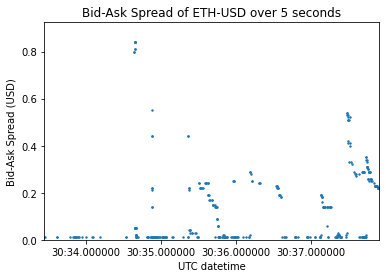

In [8]:
# bid ask spread
plt.scatter(all_events[0], all_events[6], s=2)
plt.xlim(all_events[0].iloc[0], all_events[0].iloc[-1])
plt.ylim(0, max(all_events[6])*1.1)
plt.xlabel("UTC datetime")
plt.ylabel("Bid-Ask Spread (USD)")
plt.title("Bid-Ask Spread of ETH-USD over 5 seconds")
plt.show()
# historgram of orders dsand their sizes
# market depth timeseries

## Step 5(cont.): Histogram of Events by Type
We can try seeing what the distribution of each event type was
using a histogram.
WE will plot for 
1. All events 
2. limit order insertions only
3. cancellations only
4. spread


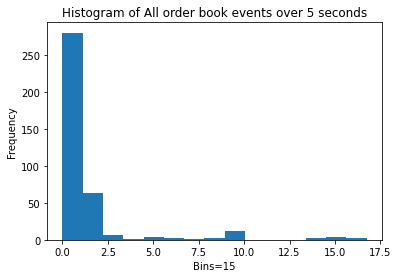

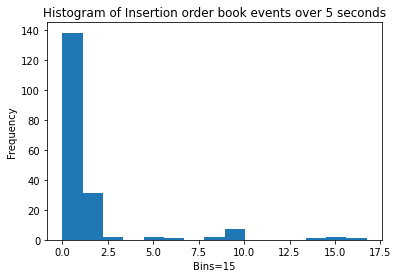

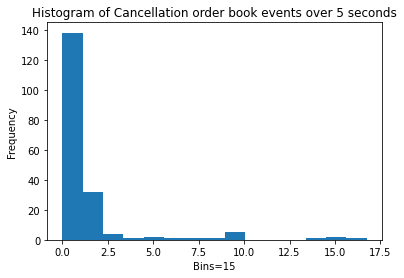

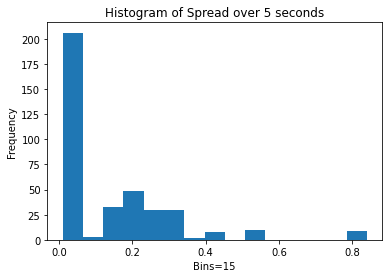

In [30]:
ins_only = all_events[all_events[1] == "insertion"]
can_only = all_events[all_events[1] == "cancelation"] # ik the typo persists in code
plot_list = [('All order book events', all_events[3]),
             ('Insertion order book events', ins_only[3]),
             ('Cancellation order book events',can_only[3]),
             ('Spread', all_events[6])]

def hist_plot(df, title):
    """ 
    Short function that plots histograms with 15 bins
    for order book events pandas.series.
    """
    df.plot.hist(bins=15)
    plt.title("Histogram of {} over 5 seconds".format(title))
    plt.xlabel("Bins=15")
    plt.show()

for i in plot_list : hist_plot(i[1], i[0])


## Step 6: Visualizing Order Book statistics
While the events file, gave us some insights into the 
way the mid price moves, and the rough empirical distribution
of the events, and spread. We can now try looking at statistics of the order book itself. 

First lets get a measurement for order book depth in total value (in USD) of the queues at 
each price level. 

In [45]:
# market depth
# retrieving the order books 
bid_prices = pd.read_excel("L2_orderbook_prices_bid2021-08-19 10:30:37.947469.xlsx")
bid_volms = pd.read_excel("L2_orderbook_volm_bid2021-08-19 10:30:37.947469.xlsx")
ask_prices = pd.read_excel("L2_orderbook_prices_ask2021-08-19 10:30:37.947469.xlsx")
ask_volms=pd.read_excel("L2_orderbook_volm_ask2021-08-19 10:30:37.947469.xlsx")

df_depth_bid = bid_volms.copy()
# multiplication of the price level by volume at each price level.
df_depth_bid['1'] = df_depth_bid['1'].mul(bid_prices['1'])
df_depth_bid['2'] = df_depth_bid['2'].mul(bid_prices['2'])
df_depth_bid['3'] = df_depth_bid['3'].mul(bid_prices['3'])
df_depth_bid['4'] = df_depth_bid['4'].mul(bid_prices['4'])
df_depth_bid['5'] = df_depth_bid['5'].mul(bid_prices['5'])
print("The Market depth at each price level at each timestep for the bid side:")
print(df_depth_bid.head())

df_depth_ask = ask_volms.copy()
df_depth_ask['1'] = df_depth_ask['1'].mul(ask_prices['1'])
df_depth_ask['2'] = df_depth_ask['2'].mul(ask_prices['2'])
df_depth_ask['3'] = df_depth_ask['3'].mul(ask_prices['3'])
df_depth_ask['4'] = df_depth_ask['4'].mul(ask_prices['4'])
df_depth_ask['5'] = df_depth_ask['5'].mul(ask_prices['5'])
print("The Market depth at each price level at each timestep for the ask side:")
print(df_depth_ask.head())


The Market depth at each price level at each timestep for the bid side:
   Unnamed: 0                    time        1            2            3  \
0           1 2021-08-19 10:30:33.448  1.34929  1761.160155  6828.682980   
1           2 2021-08-19 10:30:33.855  1.34929  1761.160155  5219.097262   
2           3 2021-08-19 10:30:33.884  1.34929  1761.160155  5219.097262   
3           4 2021-08-19 10:30:33.902  1.34929  8589.865865  5219.097262   
4           5 2021-08-19 10:30:33.908  1.34929  6828.705710  5219.097262   

             4            5  
0  5219.097262  3905.161000  
1  3905.161000  4606.644916  
2  4606.644916   150.317662  
3  4606.644916   150.317662  
4  4606.644916   150.317662  
The Market depth at each price level at each timestep for the ask side:
   Unnamed: 0                    time             1          2            3  \
0           1 2021-08-19 10:30:33.292  68929.079552  170.66377  3693.512394   
1           2 2021-08-19 10:30:33.460  53923.862126  170.6637

## Step 6(cont.): Visualizing Order Book Statistics
with a time series of the market depths at each price level, we can
now plot aggregate market depths, as the sum of the bid and ask sides
at each observation point.

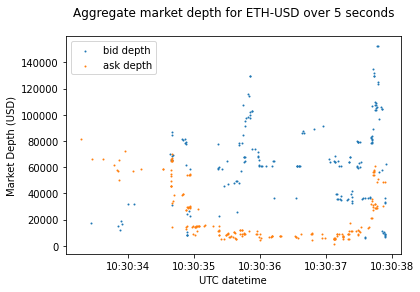

In [50]:
# plotting ask and bid depth 
df_depth_bid['sum'] = df_depth_bid['1'] + df_depth_bid['2'] + df_depth_bid['3'] + df_depth_bid['4'] + df_depth_bid['5']
df_depth_ask['sum'] = df_depth_ask['1'] + df_depth_ask['2'] + df_depth_ask['3'] + df_depth_ask['4'] + df_depth_ask['5']

plt.title("Aggregate market depth for ETH-USD over 5 seconds", pad=20)
plt.scatter(df_depth_bid['time'], df_depth_bid['sum'], s=1, label="bid depth")
plt.scatter(df_depth_ask['time'], df_depth_ask['sum'], s=1, label= "ask depth")
plt.xlabel("UTC datetime")
plt.ylabel("Market Depth (USD)")
plt.legend()
plt.show()

## Step 6(cont.): Visualizing Order Book Statistics
### Plotting Market Depth at the best bid and best ask

In the previous cell we saw that the market depth for the 5 best
bids and asks was very different. Sometimes this is a result of 
a market maker bracing for large market order, or dynamics I 
do not quite understand. 
In the cell below we plot the market depth at the best bid and ask only
as that may be more comparable.

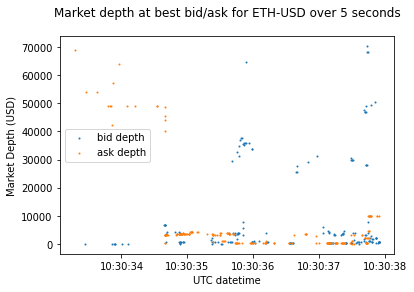

In [51]:
# plotting ask and bid depth 
plt.title("Market depth at best bid/ask for ETH-USD over 5 seconds", pad=20)
plt.scatter(df_depth_bid['time'], df_depth_bid['1'], s=1, label="bid depth")
plt.scatter(df_depth_ask['time'], df_depth_ask['1'], s=1, label= "ask depth")
plt.xlabel("UTC datetime")
plt.ylabel("Market Depth (USD)")
plt.legend()
plt.show()

## Finished!
Hopefully you have learned some basic features of crobat.crobat!

I hope this tutorial was helpful, and you can suggest more features!

The next tutorial will focus on maintaining a simple PostgreSQL database
for historically recorded orderbook messages!

 Stay tuned!


-Ivan